<a href="https://colab.research.google.com/github/sayan0506/Agriculture-project-notes-and-references/blob/main/Potato_Leaf_Classifer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Potato Leaf Classifier from Plan Village Dataset


# Import Modules

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
import pandas as pd
import seaborn as sns
import random
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.preprocessing.image import img_to_array

# Dataset Download

Published in: **18-04-2019**

[Plant_leaf_diseases_Mendeley_dataset](https://data.mendeley.com/datasets/tywbtsjrjv/1)

1. Download **Plant Village dataset without augmentation**

https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/d5652a28-c1d8-4b76-97f3-72fb80f94efc/file_downloaded


In [2]:
!wget https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/d5652a28-c1d8-4b76-97f3-72fb80f94efc/file_downloaded

--2021-03-23 21:53:02--  https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/d5652a28-c1d8-4b76-97f3-72fb80f94efc/file_downloaded
Resolving data.mendeley.com (data.mendeley.com)... 162.159.130.86, 162.159.133.86
Connecting to data.mendeley.com (data.mendeley.com)|162.159.130.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/d29ed9b2-8a5d-4663-8a82-c9174f2c7066 [following]
--2021-03-23 21:53:03--  https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/d29ed9b2-8a5d-4663-8a82-c9174f2c7066
Resolving md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)... 52.218.97.80
Connecting to md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)|52.218.97.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 868032562 (828M) [application

**Augmentation techniques used:**

Image flipping, Gamma correction, noise injection, PCA color augmentation, rotation and scaling.


2. Download **Plant Village dataset with augmentation**

https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/b4e3a32f-c0bd-4060-81e9-6144231f2520/file_downloaded

In [3]:
!wget https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/b4e3a32f-c0bd-4060-81e9-6144231f2520/file_downloaded

--2021-03-23 21:53:43--  https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/b4e3a32f-c0bd-4060-81e9-6144231f2520/file_downloaded
Resolving data.mendeley.com (data.mendeley.com)... 162.159.133.86, 162.159.130.86
Connecting to data.mendeley.com (data.mendeley.com)|162.159.133.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/349ac012-2948-4172-bbba-3bf8f76596fd [following]
--2021-03-23 21:53:44--  https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/349ac012-2948-4172-bbba-3bf8f76596fd
Resolving md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)... 52.218.1.112
Connecting to md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)|52.218.1.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 949267727 (905M) [application

## Unzipping

Degine unzipping function

In [4]:
def unzip(zip_file, content_dir):
  if not os.path.isdir(content_dir):
    os.mkdir(content_dir)

  # unzipping
  with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(content_dir)


Unzipping the dataset without Augmentation

In [5]:
# content directory
content_dir_1 = '/content/Plant Village Original'

# zip
zip_file_1 = '/content/file_downloaded' 

# unzip
unzip(zip_file_1, content_dir_1)

Unzipping the dataset with Augmentation

In [6]:
# content directory
content_dir_2 = '/content/Plant Village Augmented'

# zip
zip_file_2 = '/content/file_downloaded.1' 

# unzip
unzip(zip_file_2, content_dir_2)

# Data Inspection

In [7]:
# image directory without augmentation
img_dir_original = "/content/Plant Village Original/Plant_leave_diseases_dataset_without_augmentation"

# image directory with augmentation
img_dir_augmented = "/content/Plant Village Augmented/Plant_leave_diseases_dataset_with_augmentation"

Checking potato leaf samples category for both datasets

In [8]:
# total classifiers for original dataset
classifiers_list_original = os.listdir(img_dir_original)

# total classifiers for augmented dataset
classifiers_list_augmented = os.listdir(img_dir_augmented)

result = all(map(lambda x,y: x == y, classifiers_list_original, classifiers_list_augmented))

if result:
  print('Both dataset contains same disease classes')
  classifiers_list = classifiers_list_original
  print(f'TOtal Classifiers {len(classifiers_list)}\n')
  for i in classifiers_list:
    print(f'{i}')

else:
  print('Datasets contain different classifiers')

Both dataset contains same disease classes
TOtal Classifiers 39

Orange___Haunglongbing_(Citrus_greening)
Raspberry___healthy
Potato___Early_blight
Apple___Black_rot
Tomato___healthy
Apple___Cedar_apple_rust
Pepper,_bell___Bacterial_spot
Strawberry___Leaf_scorch
Blueberry___healthy
Tomato___Bacterial_spot
Tomato___Tomato_mosaic_virus
Apple___Apple_scab
Peach___healthy
Corn___Cercospora_leaf_spot Gray_leaf_spot
Soybean___healthy
Tomato___Spider_mites Two-spotted_spider_mite
Grape___Black_rot
Grape___healthy
Tomato___Tomato_Yellow_Leaf_Curl_Virus
Tomato___Leaf_Mold
Corn___Northern_Leaf_Blight
Potato___Late_blight
Corn___Common_rust
Pepper,_bell___healthy
Potato___healthy
Tomato___Early_blight
Strawberry___healthy
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
Peach___Bacterial_spot
Tomato___Septoria_leaf_spot
Squash___Powdery_mildew
Grape___Esca_(Black_Measles)
Tomato___Target_Spot
Background_without_leaves
Cherry___Powdery_mildew
Apple___healthy
Cherry___healthy
Corn___healthy
Tomato___Late

## Potato Leaf Samples

In [9]:
# Potato Disease Classifiers
potato_classifiers = [disease for disease in classifiers_list if disease.split('_')[0] == 'Potato']
print(f'Potato disease categories in the dataset\n{potato_classifiers}')

Potato disease categories in the dataset
['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


Function for image to array conversion using keras  

In [10]:
def convert_img_to_array(image_path):
  try:
    img = plt.imread(image_path)
    if img is not None:
      return img_to_array(img)
    else:
      return np.array([])
  
  except Exception as e:
    print(f'Error {e}')
    return None


**Defining function for creating image array
 and labels list from the folder**

In [11]:
def fetch_img(img_dir):

  potato_classifiers_path = [os.path.join(img_dir, disease) for disease in potato_classifiers]
  print(f'Potato directory names list {potato_classifiers_path}')
  # image array list
  image_list = []
  # image labels list
  label_list = []
  # label_dataframe
  label_df = pd.DataFrame(columns=potato_classifiers)
  # image dataframe
  img_df = pd.DataFrame(columns=['Image', 'Shape', 'Label'])

  try:
    print('\n[INFO] Loading images ...')
    # total sample count
    sample_count = 0
    for sr, potato_disease_path in enumerate(potato_classifiers_path):
      print(f'[INFO] Processing {potato_classifiers[sr]}')
      sample_list = os.listdir(potato_disease_path)
      #print(len(sample_list))
      for disease_sample in sample_list:
        # removing the .DS_store files from list, which contains the folder infos
        if disease_sample == '.DS_store':
          sample_list.remove(disease_sample)
      # categorical count
      count = 0
      for disease_sample in sample_list:
        disease_sample_path = os.path.join(potato_disease_path, disease_sample)
        if disease_sample_path.endswith(".jpg") == True or disease_sample_path.endswith(".JPG") == True:
          img = convert_img_to_array(disease_sample_path)
          image_list.append(img)
          label_list.append(potato_classifiers[sr])
          img_df.loc[sample_count,'Image'], img_df.loc[sample_count,'Label'] = disease_sample, potato_classifiers[sr]
          img_df.loc[sample_count,'Shape'] = img.shape
          count += 1
          sample_count += 1
      label_df.loc[0, potato_classifiers[sr]] = count

    return image_list, label_list, label_df, img_df   
      
  except Exception as e:
    print(f'Error {e}')
    return None

#### **Fetching Potato images path for 3 classes for original dataset**

In [12]:
# main image directory
img_dir_original = "/content/Plant Village Original/Plant_leave_diseases_dataset_without_augmentation"

print(f'Image directory {img_dir_original}\n')

# fetching image array list, label_list, label_array, image_array
image_list_original, label_list_original, label_df_original, img_df_original = fetch_img(img_dir_original)


if len(image_list_original) == len(label_list_original):
  print('\nCheck Successful for original datasets')
  print(f'Total original Potato Image samples {len(image_list_original)}\n')
  print(f'Label dataframe original\n')

else:
  print('Verify Dataloader or work on labelling')

label_df_original

Image directory /content/Plant Village Original/Plant_leave_diseases_dataset_without_augmentation

Potato directory names list ['/content/Plant Village Original/Plant_leave_diseases_dataset_without_augmentation/Potato___Early_blight', '/content/Plant Village Original/Plant_leave_diseases_dataset_without_augmentation/Potato___Late_blight', '/content/Plant Village Original/Plant_leave_diseases_dataset_without_augmentation/Potato___healthy']

[INFO] Loading images ...
[INFO] Processing Potato___Early_blight
[INFO] Processing Potato___Late_blight
[INFO] Processing Potato___healthy

Check Successful for original datasets
Total original Potato Image samples 2152

Label dataframe original



,Potato___Early_blight,Potato___Late_blight,Potato___healthy
0,1000,1000,152


#### **Fetching Potato images path for 3 classes for augmented dataset**

In [13]:
# main image directory with augmentation
img_dir_augmented = "/content/Plant Village Augmented/Plant_leave_diseases_dataset_with_augmentation"

print(f'Image directory with augmentation {img_dir_augmented}\n')

# fetching image array list, label_list, label_array, image_array
image_list_augmented, label_list_augmented, label_df_augmented, img_df_augmented = fetch_img(img_dir_augmented)


if len(image_list_augmented) == len(label_list_augmented):
  print('\nCheck Successful for augmented datasets')
  print(f'Total Potato Image samples in augmented datasets {len(image_list_augmented)}\n')
  print(f'Label dataframe augmented\n')

else:
  print('Verify Dataloader or work on labelling')

label_df_augmented

Image directory with augmentation /content/Plant Village Augmented/Plant_leave_diseases_dataset_with_augmentation

Potato directory names list ['/content/Plant Village Augmented/Plant_leave_diseases_dataset_with_augmentation/Potato___Early_blight', '/content/Plant Village Augmented/Plant_leave_diseases_dataset_with_augmentation/Potato___Late_blight', '/content/Plant Village Augmented/Plant_leave_diseases_dataset_with_augmentation/Potato___healthy']

[INFO] Loading images ...
[INFO] Processing Potato___Early_blight
[INFO] Processing Potato___Late_blight
[INFO] Processing Potato___healthy

Check Successful for augmented datasets
Total Potato Image samples in augmented datasets 3000

Label dataframe augmented



,Potato___Early_blight,Potato___Late_blight,Potato___healthy
0,1000,1000,1000


## Target Analysis

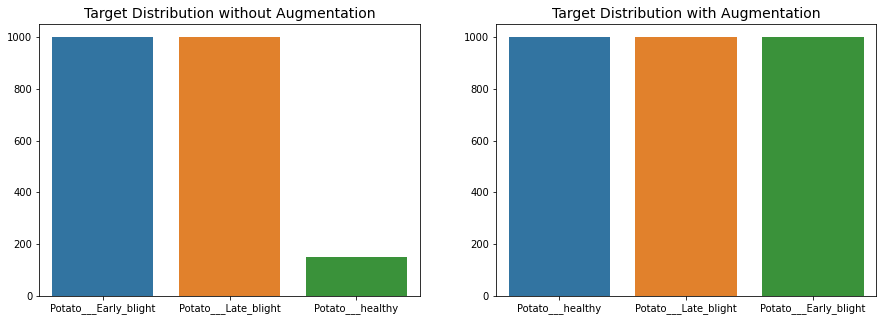

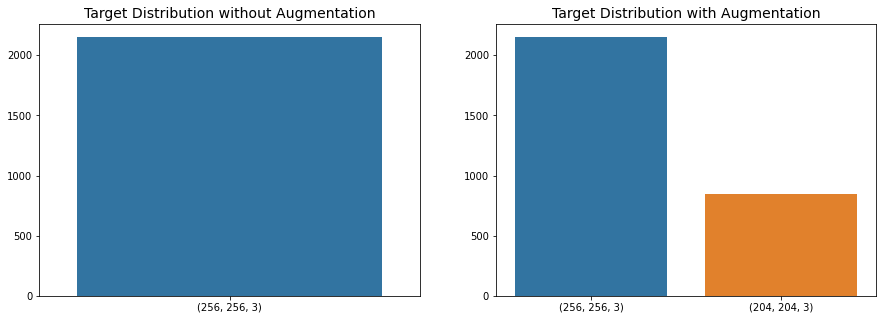

In [14]:
# target distribution visualize between original and augmented images
def distribution(counts_series_original, counts_series_augmented):
  fig = plt.figure(figsize=(15,5))
  fig.add_subplot(121)
  sns.barplot(x = counts_series_original.index, y = counts_series_original.values)
  plt.title('Target Distribution without Augmentation', fontsize=14)
  fig.add_subplot(122)
  sns.barplot(x = counts_series_augmented.index, y = counts_series_augmented.values)
  plt.title('Target Distribution with Augmentation', fontsize=14)

# returns pandas series with classes as keys and count as values for original dataset
target_counts_original = img_df_original['Label'].value_counts()

# returns pandas series with classes as keys and count as values for augmented dataset
target_counts_augmented = img_df_augmented['Label'].value_counts()

# shape analysis for original
shape_counts_original = img_df_original['Shape'].value_counts()

# shape analysis for augmented
shape_counts_augmented = img_df_augmented['Shape'].value_counts()

# visualize target distribution comparison
distribution(target_counts_original, target_counts_augmented)

# visualize shapes distribution comparison
distribution(shape_counts_original, shape_counts_augmented)

* **We can check the data is imbalanced, where very less Healthy image available**
* **All the images are of similar shapes for original datasets (256,256,3)**
* **For Augmented datasets total images are 3000, where each class contains 1000 samples.**
* **In augmented datasets some are of shape (256,256,3), and some are of shape (204,204,3).**

## Augmented Image Shapes EDA

Image shape comparison between different categories 

Shape          Label                
(256, 256, 3)  Potato___Late_blight     1000
               Potato___Early_blight    1000
(204, 204, 3)  Potato___healthy          848
(256, 256, 3)  Potato___healthy          152
dtype: int64



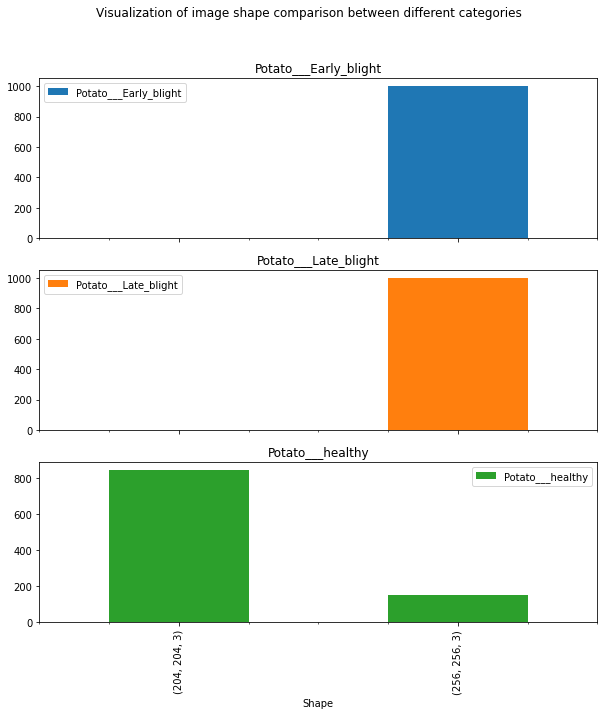

In [15]:
level_shape_df = img_df_augmented[['Shape', 'Label']].value_counts()
print(f'Image shape comparison between different categories \n\n{level_shape_df}\n')

# plotting the multi-index dataframe's hist() plot, where label, and shape are two index
level_shape_df.unstack(level = 1).plot(kind = 'bar', subplots = True, figsize = (10,10), 
                                       title = 'Visualization of image shape comparison between different categories')
plt.show()

**From the above analysis in Augmented dataset,**
* **"Potato_healthy" contains 152 samples which are similar size of (256,256,3) with the other two potato disease classes.**
* **848 samples of "Potato_healthy" category are of size (204,204,3)**
* **Thus, we need to resize them to a default shape (256,256,3)**

## Augmented images interpolation

Here one of the two common interpolation will be used 
1. Bi-linear spline interpolation
2. Bi-cubic spline interpolation

The comparison between these interpolations will be analyzed

Image index 2241
Augmented image shape before interpolation: (204, 204, 3)



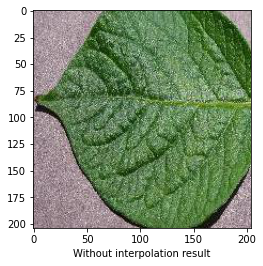

In [16]:
# random sample of augmented image of shape (204,204,3)
aug_img_indices = [sr for sr, img in enumerate(image_list_augmented) if img.shape == (204,204,3)]
a = random.choice(aug_img_indices)
print(f'Image index {a}')
img_a = image_list_augmented[a]
# sample augmented image of size (204,204,3) is used to compare the interpolations
print(f'Augmented image shape before interpolation: {img_a.shape}\n')
plt.imshow(np.array(img_a, dtype = np.float32)/255.0)
plt.xlabel('Without interpolation result')
plt.show()

Interpolation checks

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


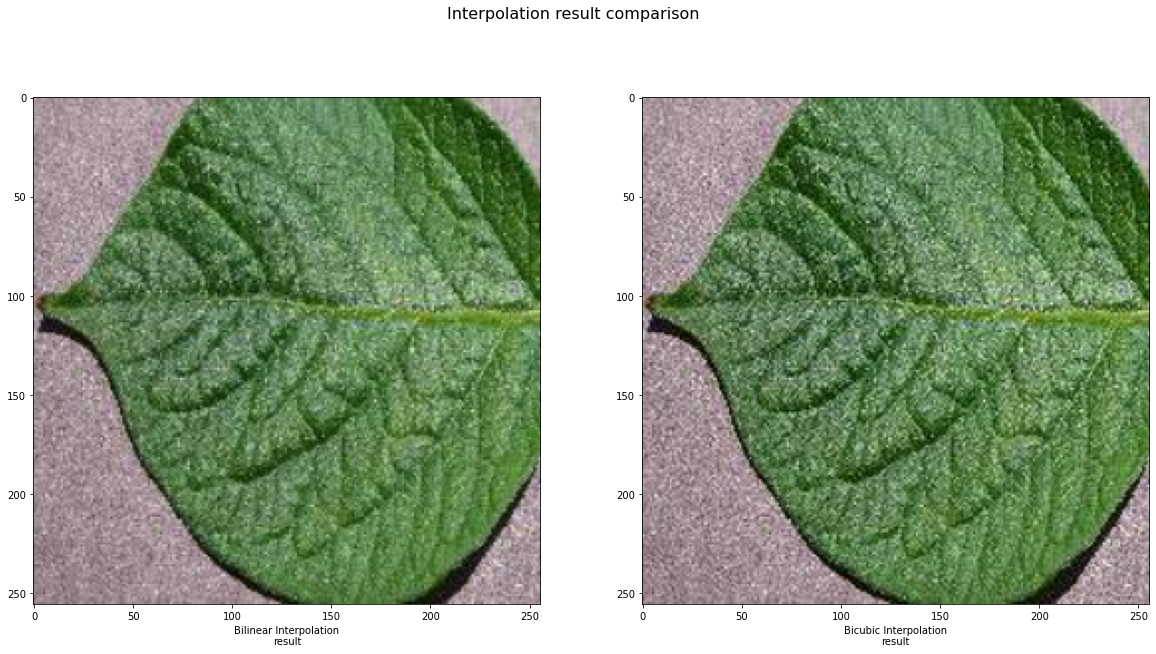

In [17]:
# applying bilinear spline interpolation
b1 = tf.keras.preprocessing.image.smart_resize(img_a, size=(256,256), interpolation='bilinear')
b1 = np.array(b1, dtype=np.float32)/255.0

# applying bicubic spline interpolation
b2 = tf.keras.preprocessing.image.smart_resize(img_a, size=(256,256), interpolation='bicubic')
b2 = np.array(b2, dtype=np.float32)/255.0

# visualize
fig = plt.figure(figsize = (20,10))
fig.suptitle('Interpolation result comparison', fontsize = 16)
fig.add_subplot(121)
plt.imshow(b1)
plt.xlabel('Bilinear Interpolation\nresult')
fig.add_subplot(122)
plt.xlabel('Bicubic Interpolation\nresult')
plt.imshow(b2)
plt.show()

Error: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
[Reference](https://www.kaggle.com/c/ann-and-dl-image-segmentation/discussion/120550)

**Review:**
It is closely observed that, cubic spline resized a bit detailed or less blurry result, so finalizing "Bi-cubic spline interpolation", for resizing augmented image samples.


# Data Preparation

#### Resizing augmented images

Fetching augmented image index to be resized along with testing

In [18]:
print(f'Augmented datasets shape analysis: \n{shape_counts_augmented}')

Augmented datasets shape analysis: 
(256, 256, 3)    2152
(204, 204, 3)     848
Name: Shape, dtype: int64


In [19]:
# index list of augmented images
augment_index_list = [i for i, image in enumerate(image_list_augmented) if image.shape==(204, 204, 3)]

# test for index list fetching
if len(augment_index_list) == shape_counts_augmented.values[1]:
  print(f'Test passed, {len(augment_index_list)} Augmented images are there in the dataset to be resized ')
else:
  print('Check steps')  

Test passed, 848 Augmented images are there in the dataset to be resized 


**Resizing images**

In [20]:
default_image_size = (256,256)
for sr in augment_index_list:
  image_list_augmented[sr] = tf.keras.preprocessing.image.smart_resize(image_list_augmented[sr], 
                                                                       size=default_image_size, interpolation='bicubic')

# storing index having image shape (204,204,3) after interpolation
augment_index_list_resized1 = [i for i, image in enumerate(image_list_augmented) if image.shape==(204, 204, 3)]
augment_index_list_resized12 = [i for i, image in enumerate(image_list_augmented) if image.shape==(256, 256, 3)]

Testing interpolation step

In [21]:
# resize check
if len(augment_index_list_resized1) == 0 and len(augment_index_list_resized12) == len(image_list_augmented):
  print('Test passed, no images lef of size (204,204,3) in the list')
  print(f'All images have of equal shape (256,256,3) of size {len(image_list_augmented)}') 
else:
  print('Test failed, check implementation')

Test passed, no images lef of size (204,204,3) in the list
All images have of equal shape (256,256,3) of size 3000


## Transforming image labels using Scikit Learn's LabelBinarizer

Defining one hot encodings for output labels 

In [23]:
# binarizing the original dataset labels
image_labels_original = LabelBinarizer().fit_transform(label_list_original) 

# binarizing the augmented dataset labels
image_labels_augmented = LabelBinarizer().fit_transform(label_list_augmented) 

# sample image label
label_sample1 = image_labels_augmented[0]
label_sample2 = image_labels_augmented[1000]
label_sample3 = image_labels_augmented[2000]
print(f'Sample binarized label: \n')
print(f'{label_sample1}, class: {potato_classifiers[list(label_sample1).index(1)]}')
print(f'{label_sample2}, class: {potato_classifiers[list(label_sample2).index(1)]}')
print(f'{label_sample3}, class: {potato_classifiers[list(label_sample3).index(1)]}')

Sample binarized label: 

[1 0 0], class: Potato___Early_blight
[0 1 0], class: Potato___Late_blight
[0 0 1], class: Potato___healthy


## Converting images to numpy array and Normalizing

In [24]:
# numpy array for original image list
image_list_original = np.array(image_list_original, dtype = np.float32)/255.0

# numpy array for augmented image list
image_list_augmented = np.array(image_list_augmented, dtype = np.float32)/255.0

print(f'Shape of original np dataset {image_list_original.shape}')
print(f'Shape of augmented np dataset {image_list_augmented.shape}')

Shape of original np dataset (2152, 256, 256, 3)
Shape of augmented np dataset (3000, 256, 256, 3)


## Shuffle datasets and Visualization

Shuffling original dataset and visualizing

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


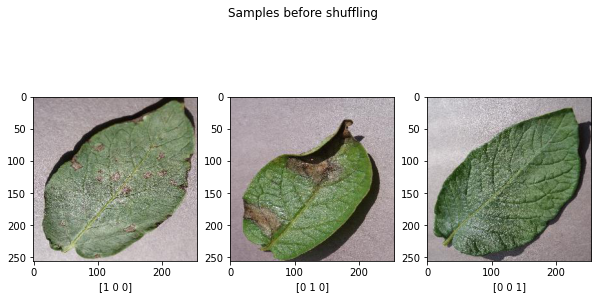

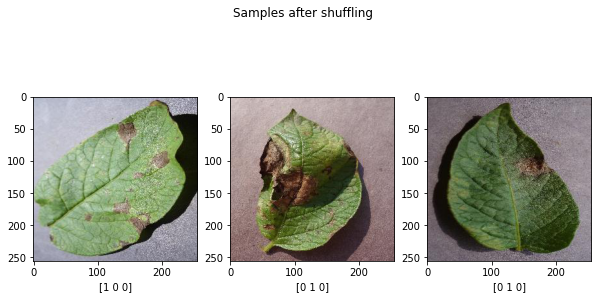

In [26]:
fig1 = plt.figure(figsize = (10,5))
fig1.suptitle('Samples before shuffling')
fig1.add_subplot(131), plt.imshow(image_list_original[0]), plt.xlabel(image_labels_original[0])
fig1.add_subplot(132), plt.imshow(image_list_original[1000]), plt.xlabel(image_labels_original[1000])
fig1.add_subplot(133), plt.imshow(image_list_original[2000]), plt.xlabel(image_labels_original[2000])
# shuffling original dataset
image_list_original, image_labels_original = shuffle(image_list_original, image_labels_original)
fig2 = plt.figure(figsize = (10,5))
fig2.suptitle('Samples after shuffling')
fig2.add_subplot(131), plt.imshow(image_list_original[0]), plt.xlabel(image_labels_original[0]) 
fig2.add_subplot(132), plt.imshow(image_list_original[1000]), plt.xlabel(image_labels_original[1000]) 
fig2.add_subplot(133), plt.imshow(image_list_original[2000]), plt.xlabel(image_labels_original[2000])
plt.show()

Shuffling original augmented dataset and visualizing

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


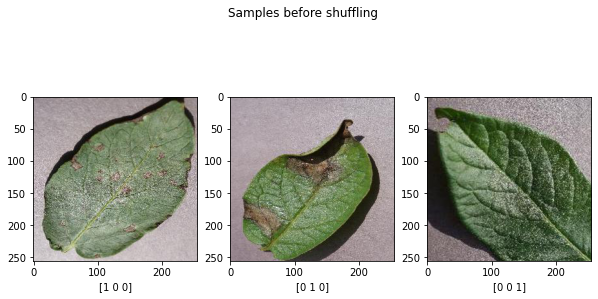

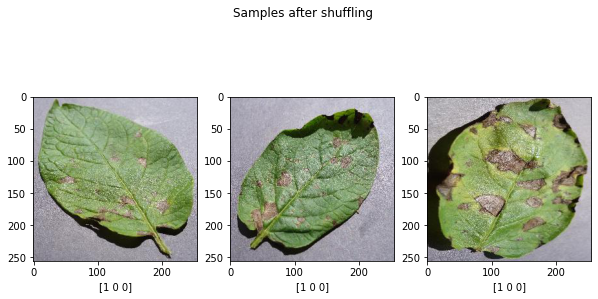

In [28]:
fig1 = plt.figure(figsize = (10,5))
fig1.suptitle('Samples before shuffling')
fig1.add_subplot(131), plt.imshow(image_list_augmented[0]), plt.xlabel(image_labels_augmented[0])
fig1.add_subplot(132), plt.imshow(image_list_augmented[1000]), plt.xlabel(image_labels_augmented[1000])
fig1.add_subplot(133), plt.imshow(image_list_augmented[2000]), plt.xlabel(image_labels_augmented[2000])
# shuffling augmented dataset
image_list_augmented, image_labels_augmented = shuffle(image_list_augmented, image_labels_augmented)

fig2 = plt.figure(figsize = (10,5))
fig2.suptitle('Samples after shuffling')
fig2.add_subplot(131), plt.imshow(image_list_augmented[0]), plt.xlabel(image_labels_augmented[0])
fig2.add_subplot(132), plt.imshow(image_list_augmented[1000]), plt.xlabel(image_labels_augmented[1000])
fig2.add_subplot(133), plt.imshow(image_list_augmented[2000]), plt.xlabel(image_labels_augmented[2000])
plt.show()

## Splitting the data into train and test set

In [30]:
x_train_original, x_test_original, y_train_original, y_test_original = train_test_split(image_list_original, image_labels_original,
                                                                                        test_size = 0.2, random_state = 42)

print(x_train_original.shape, x_test_original.shape)

(1721, 256, 256, 3) (431, 256, 256, 3)


Tasks:
1. Load labels array to a dataframe for train and test, original and augmented 
2. Replace the encodings to srings in the dataframe
3. Plot the different class counts in bar lot for train, test in same plot



Sample visualization of 5 of each different categories


In [168]:
potato_classifiers_path[0]

'/content/Plant Village Original/Plant_leave_diseases_dataset_without_augmentation/Potato___healthy'